In [11]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

env = gym.make("CartPole-v1", render_mode="rgb_array").unwrapped
plt.ion()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
from matplotlib import font_manager
font_fname = "C:/Windows/Fonts/malgun.ttf"
font_family = font_manager.FontProperties(fname=font_fname).get_name()
plt.rcParams["font.family"] = font_family

In [13]:
Transition = namedtuple("Transition", ("state", "action", "next_state", "reward"))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        
    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [14]:
class DQN(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        
        def conv2d_size_out(size, kernel_size=5, stride=2):
            return (size - (kernel_size - 1) - 1) // stride + 1
        
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

C:\Users\amil0\AppData\Local\Temp\ipykernel_22888\1326023502.py:3: DeprecationWarning: CUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use BICUBIC or Resampling.BICUBIC instead.
  resize = T.Compose([T.ToPILImage(), T.Resize(40, interpolation=Image.CUBIC), T.ToTensor()])


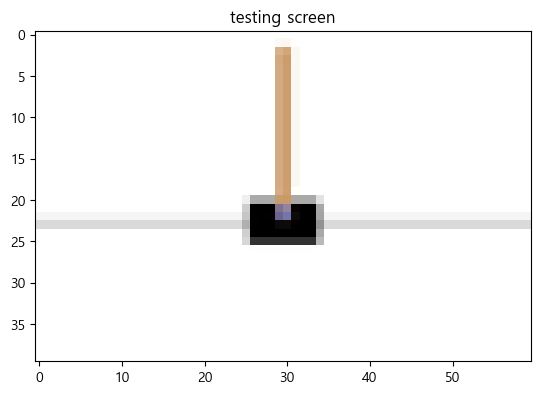

In [15]:
import pyglet

resize = T.Compose([T.ToPILImage(), T.Resize(40, interpolation=Image.CUBIC), T.ToTensor()])

def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)

def get_screen():
    screen = env.render().transpose((2, 0, 1))
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height * 0.4):int(screen_width * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2, cart_location + view_width // 2)
    screen = screen[:, :, slice_range]
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    return resize(screen).unsqueeze(0).to(device)

env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(), interpolation="none")
plt.title("testing screen")
plt.show()

In [16]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape
n_actions = env.action_space.n
policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)
    
episode_durations = []

In [17]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return 
    
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

버틴시간 리스트 [74, 11, 11, 18, 14, 11, 57, 29, 36, 32, 35, 13, 13, 13, 30, 12, 12, 21, 25, 23, 21, 72, 97, 93, 11, 26, 52, 50, 32, 14, 77, 78, 26, 69, 56, 48, 13, 59, 40, 63, 69, 31, 33, 17, 29, 23, 63, 16, 60, 31, 36, 34, 19, 44, 107, 33, 53, 186, 50, 58, 37, 92, 22, 28, 13, 13, 90, 31, 43, 16, 14, 14, 35, 39, 41, 86, 24, 18, 88, 14, 87, 8, 22, 21, 14, 14, 10, 16, 11, 45, 26, 16, 13, 23, 12, 10, 22, 44, 12, 10, 98, 23, 28, 37, 17, 14, 24, 13, 10, 28, 63, 11, 9, 14, 86, 18, 15, 44, 16, 47, 10, 18, 18, 12, 19, 32, 12, 11, 45, 14, 27, 11, 10, 11, 20, 27, 15, 24, 11, 16, 10, 18, 14, 25, 11, 42, 17, 65, 10, 13, 20, 21, 13, 81, 16, 14, 18, 21, 11, 13, 11, 47, 157, 35, 53, 34, 15, 27, 30, 13, 77, 11, 14, 21, 13, 33, 12, 20, 22, 9, 11, 18, 15, 12, 12, 8, 21, 17, 15, 17, 17, 13, 26, 13, 10, 33, 10, 10, 11, 18, 9, 10, 9, 12, 12, 10, 12, 12, 17, 10, 24, 26, 97, 20, 27, 37, 65, 26, 13, 13, 26, 117, 18, 37, 36, 13, 57, 18, 42, 40, 25, 55, 69, 26, 93, 11, 30, 97, 85, 38, 32, 42, 76, 16, 21, 18, 103, 64,

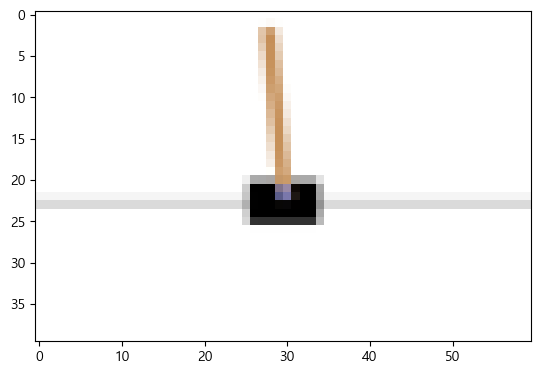

In [ ]:
from IPython.display import clear_output

num_episodes = 5000

t_li = []
for i_episode in range(num_episodes):
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen

    for t in count():
        action = select_action(state)
        _, reward, done, _, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        last_screen = current_screen
        current_screen = get_screen()

        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        memory.push(state, action, next_state, reward)
        state = next_state

        optimize_model()
        # plt imshow in jupyter notebook update same figure
        clear_output(wait=True)
        plt.imshow(
            get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(), interpolation="none"
        )
        print("List of endured times", t_li)
        plt.show()
        if done:
            episode_durations.append(t + 1)
            t_li.append(t + 1)
            break
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

    print("Complete")

plt.title("screen")
env.render()
env.close()
plt.show()